In [17]:
import numpy as np
import pandas as pd
import math
import os
import sys
import glob
import time
import pickle
import time
import itertools
import altair as alt
alt.data_transformers.disable_max_rows()

from astropy import units as u
from astropy.timeseries import LombScargle

import fastdtw
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

import multiprocessing as mp
from multiprocessing import Pool
print("Number of processors: ", mp.cpu_count())

sys.path.append('/astro/users/jbirky/projects/tess_binaries')
os.environ['TESS_DATA'] = '/data/epyc/projects2/tess'

import tess_binaries as tb

Number of processors:  96


### Literature

With Semi-supervised learning:
- [DTW-D: Time Series Semi-Supervised Learning from a Single Example](http://chbrown.github.io/kdd-2013-usb/kdd/p383.pdf) 
- [Scaling up Dynamic Time Warping to Massive Datasets](http://www.cs.ucr.edu/~eamonn/pkdd99keogh_pazzani.pdf)

Implementations:
- [FastDTW: Toward Accurate Dynamic Time Warping in Linear Time and Space](https://pdfs.semanticscholar.org/05a2/0cde15e172fc82f32774dd0cf4fe5827cad2.pdf)

Astronomical applications:
- [Unsupervised Classification of Variable Stars](https://arxiv.org/pdf/1801.09723.pdf)
- [Central Engine Memory of Gamma-Ray Bursts and Soft Gamma-Ray Repeaters](https://arxiv.org/abs/1603.01381)
- [Reconstructing Gravitational Wave Core-Collapse Supernova Signals with Dynamic Time Warping](https://arxiv.org/abs/1901.02535)

### First Test:

1. pick out 5 source types: EA, EB, EW, ROT, RRAB (x2 of each)
2. phase fold light curve using ASASSN period (manually picked out good periods)
3. bin into uniform time grid
4. compute distances for all (10 choose 2)=45 combinations using metrics:
 - euclidean distance
 - dynamic time warping
 - DTW-D = DTW / ED

Future things:
- amplitude scaling (affine transformation versions of DTW)?

### Read in ASASSN reference list

In [2]:
tess_xm = pd.read_csv(tb.cat_dir + '/asassn_tess_xm.csv.gz')
psamp = tess_xm[~np.isnan(tess_xm['period'])]
ref = psamp[psamp['period'] < 28]

pos_ref = ref[ref['Type'].isin(['EA', 'EB', 'EW'])]
neg_ref = ref[~ref['Type'].isin(['EA', 'EB', 'EW'])]
print(len(pos_ref), len(neg_ref))

656 750


In [ ]:
pos_ref['Type'].value_counts().plot(kind='bar', figsize=[18,6])

In [ ]:
neg_ref['Type'].value_counts().plot(kind='bar', figsize=[18,6])

In [ ]:
# Hold out reference data
pos_train = pos_ref[0:300]
neg_train = neg_ref[0:300]

pos_test = pos_ref[300:]
neg_test = neg_ref[300:]

In [ ]:
np.where(np.array(ref['Type']) == 'EA')

### Phase Fold and bin data

5 EA


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


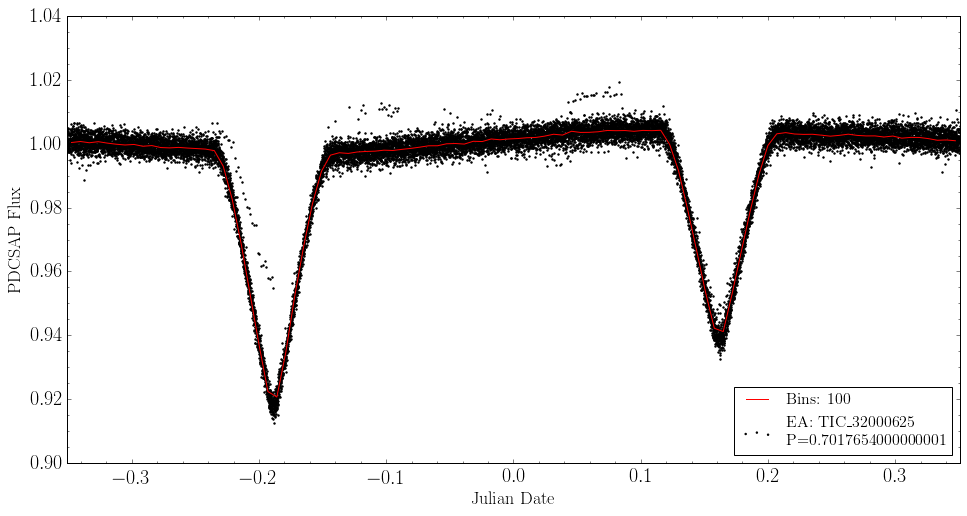

16 EA


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


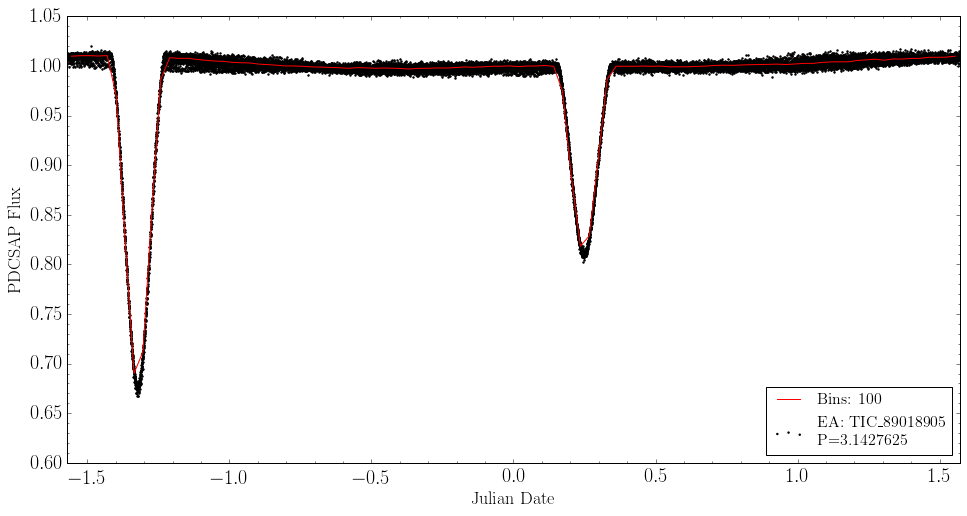

20 EB
Stacking 1 light curve(s).


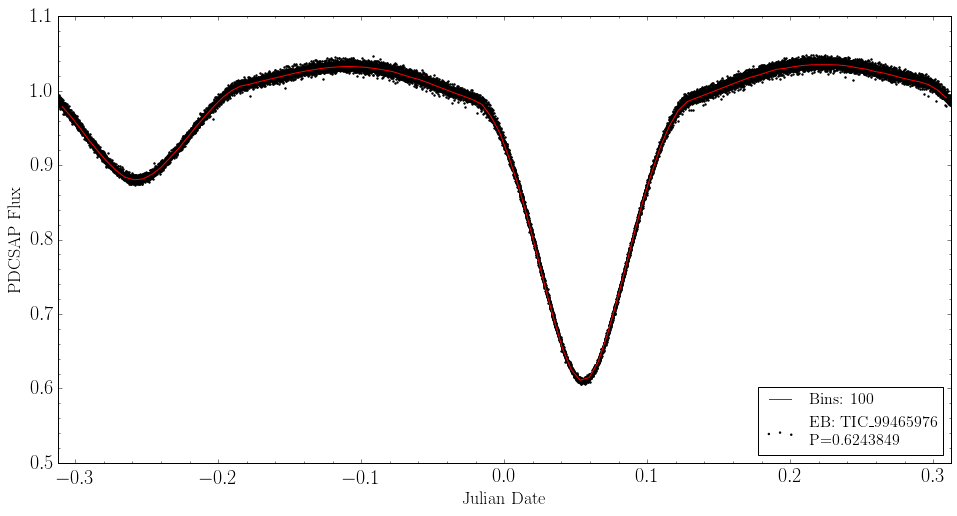

25 EB
Stacking 1 light curve(s).


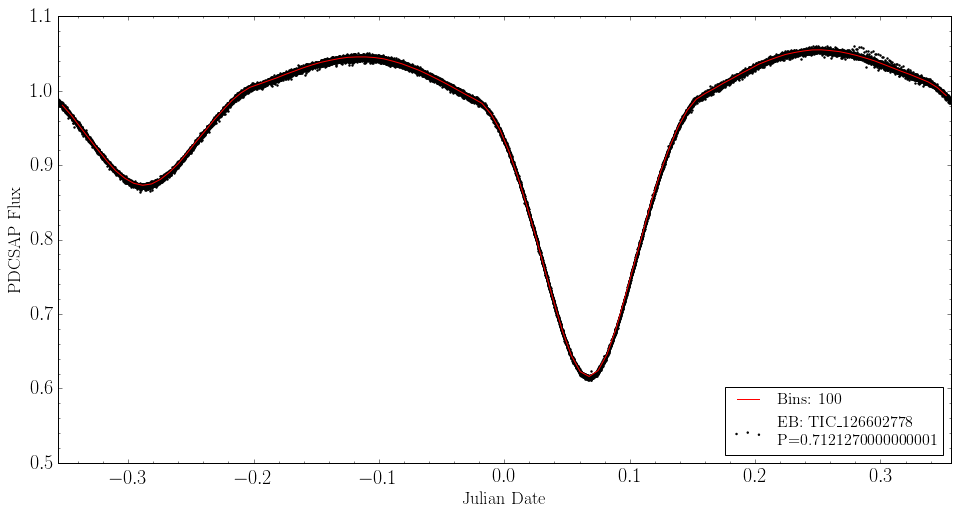

4 EW
Stacking 1 light curve(s).


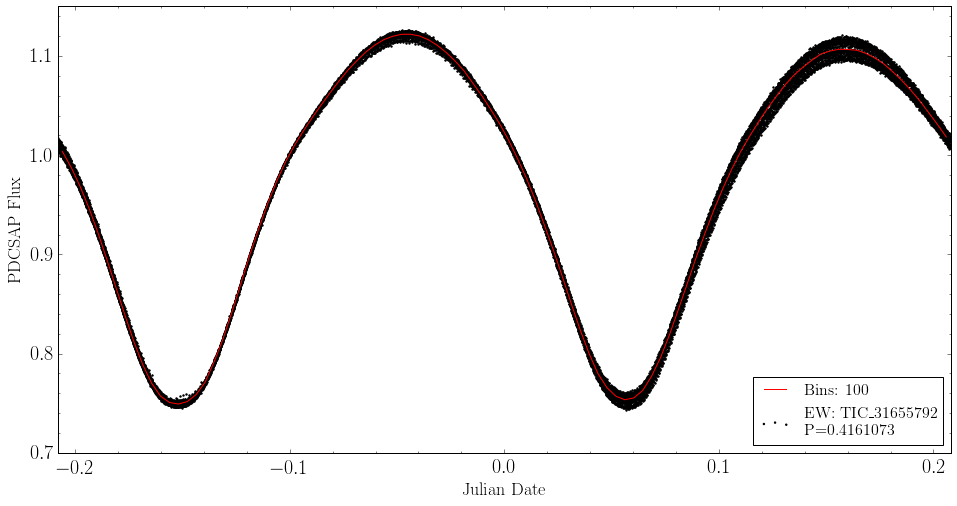

6 EW
Stacking 1 light curve(s).


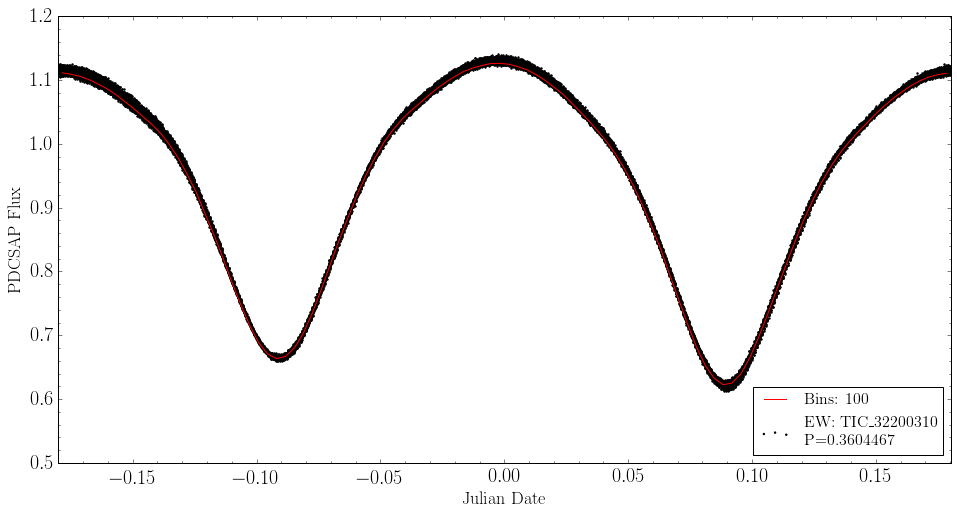

14 ROT
Stacking 1 light curve(s).


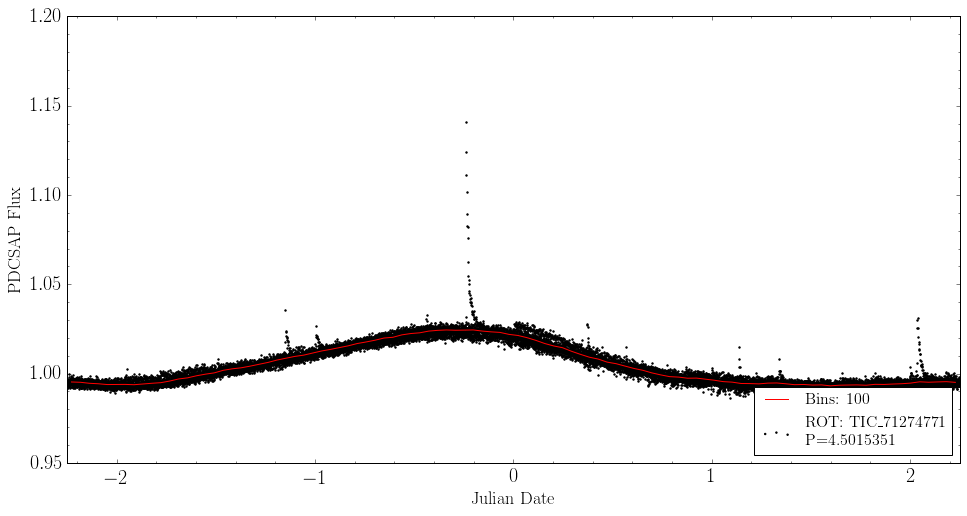

21 ROT
Stacking 1 light curve(s).


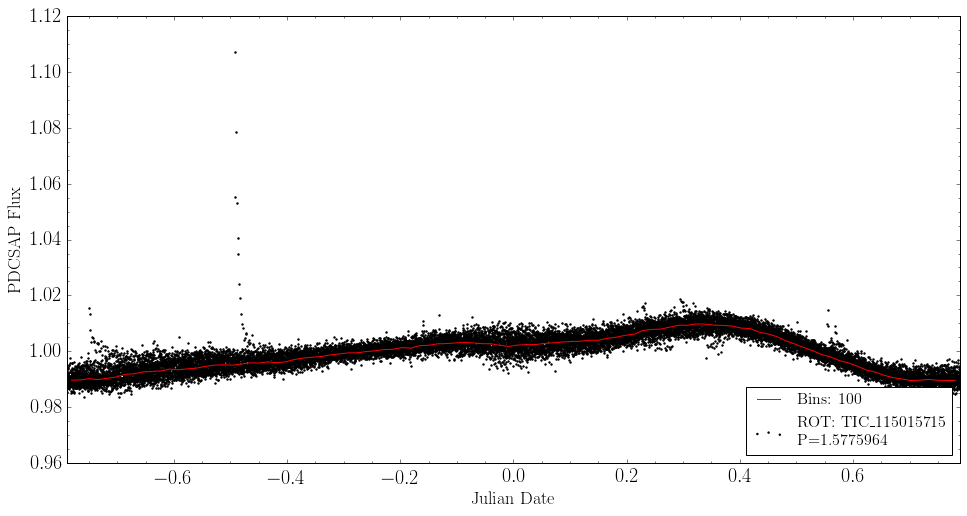

62 RRAB
Stacking 1 light curve(s).


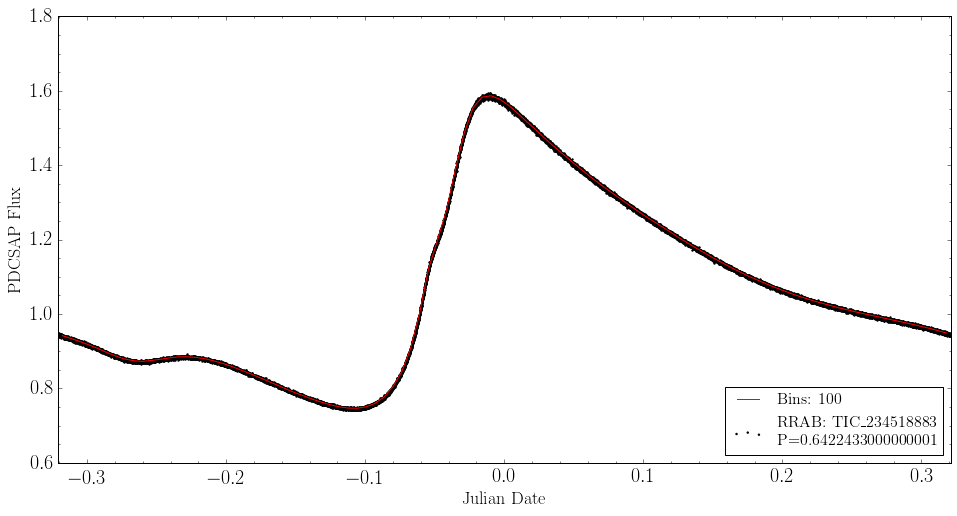

117 RRAB
Stacking 1 light curve(s).


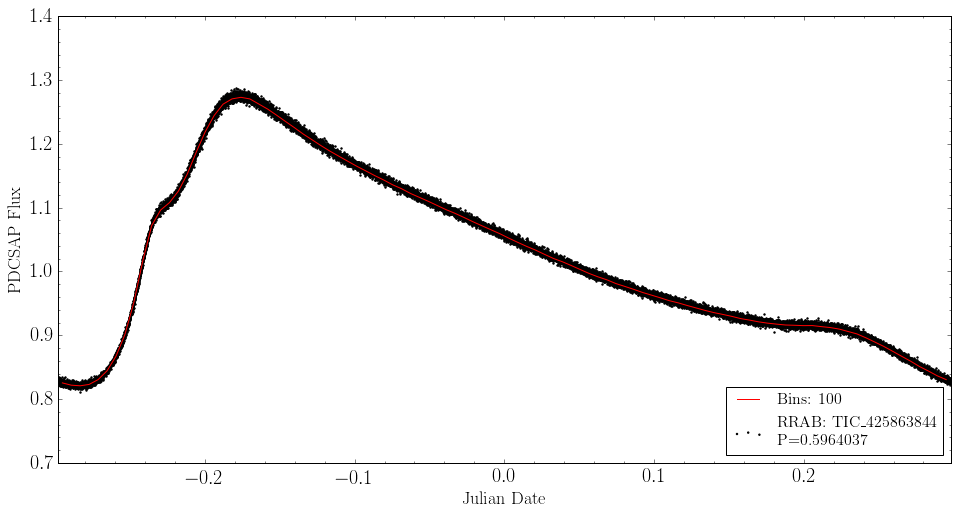

In [3]:
tsteps = 100
tarr = np.arange(0,tsteps,1)
farr = []
ids = []
periods = []
types = []

demo = [5,16, 20,25, 4,6, 14,21, 62,117]


for i in demo:
    tic_id = list(ref['tic_id'])[i]
    sec = list(ref['sector'])[i]
    typ = list(ref['Type'])[i]
    per = list(ref['period'])[i]
    print(i, typ)
    
    data_full = tb.readSourceFiles(tic_id, sector=sec)[0]
    
#     ts = data_full[~np.isnan(data_full['pdcsap_flux'])]
#     ls =  LombScargle(ts.time.jd, ts['pdcsap_flux'], dy=ts['pdcsap_flux_err'], \
#                       normalization='standard')
#     ls_freq, ls_power = ls.autopower(minimum_frequency=.001, \
#                           maximum_frequency=100, samples_per_peak=10)
#     ls_pwr_spec  = np.vstack([np.array(1/ls_freq), np.array(ls_power)])
#     ls_max_pwr = np.argmax(ls_pwr_spec, axis=1)[1]
#     per = ls_pwr_spec[0][ls_max_pwr]
    
    data = data_full.fold(period=per*u.day) 
#     plotLightCurve(data, label=f"{typ}: TIC_{tic_id}\nP={per}", save_dir=f'{tb.plot_dir}/dtw_ex_classes', tic_id=tic_id)

    tbins = np.linspace(min(data.time.jd), max(data.time.jd), tsteps+1)
    bin_width = (tbins[1] - tbins[0])/2
    bin_flux = []
    for i in range(tsteps):
        bin_ind = np.where((data.time.jd > tbins[i]) & (data.time.jd < tbins[i+1]))[0]
        bin_flux.append(np.nanmedian(data['pdcsap_flux'][bin_ind])/u.electron*u.second)
    bin_flux = np.array(bin_flux)/np.median(np.array(bin_flux))

    plt.figure(figsize=[16,8])
    plt.ticklabel_format(useOffset=False)
    plt.scatter(data.time.jd, data['pdcsap_flux']/np.nanmedian(data['pdcsap_flux']), \
             color='k', s=2, label=f"{typ}: TIC\_{tic_id}\nP={per}")
    plt.plot(tbins[:tsteps]+bin_width, bin_flux, color='r', label=f'Bins: {tsteps}')

    plt.ylabel('PDCSAP Flux', fontsize=18)
    plt.xlabel('Julian Date', fontsize=18)
    plt.xlim(min(data.time.jd), max(data.time.jd))
    plt.legend(loc='lower right', fontsize=16)
    plt.minorticks_on()
    plt.savefig(f'{tb.plot_dir}/dtw_ex_classes/TIC_{tic_id}.png')
    plt.show() 
    
    farr.append(bin_flux)
    ids.append(tic_id)
    periods.append(per)
    types.append(typ)

In [4]:
# combos = list(itertools.combinations(np.arange(0,10), 2))
combos = [(0,1), (0,3), (0,5), (0,7), (0,9)]

### Euclidean Distance

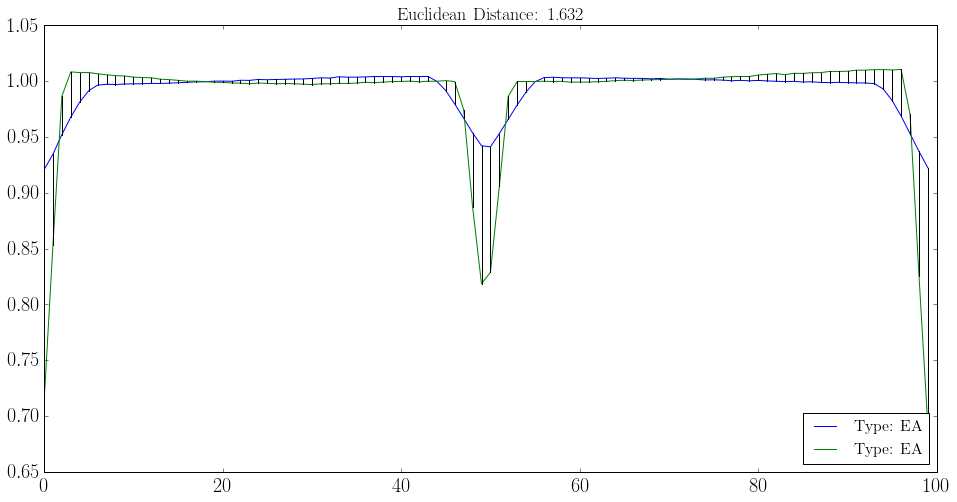

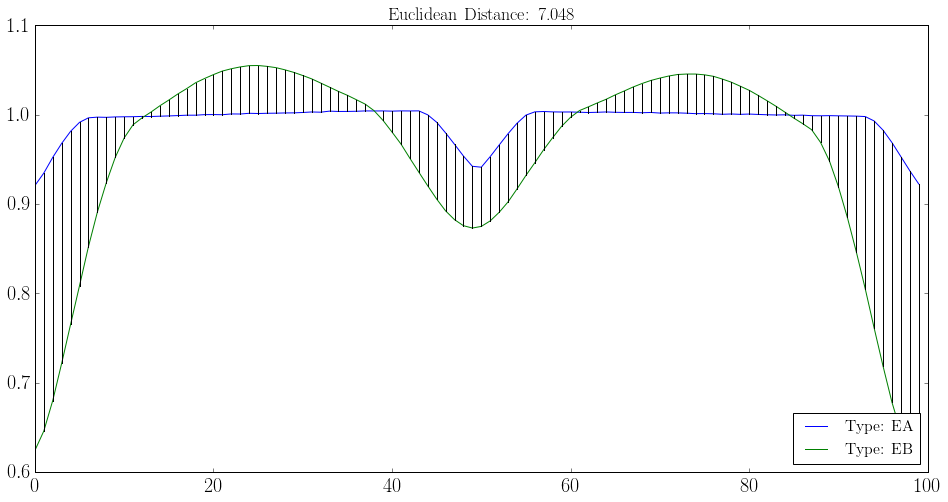

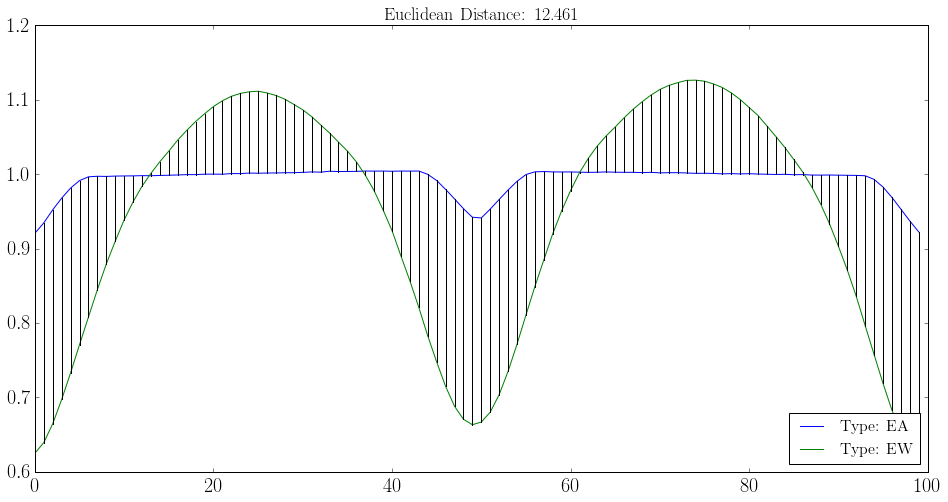

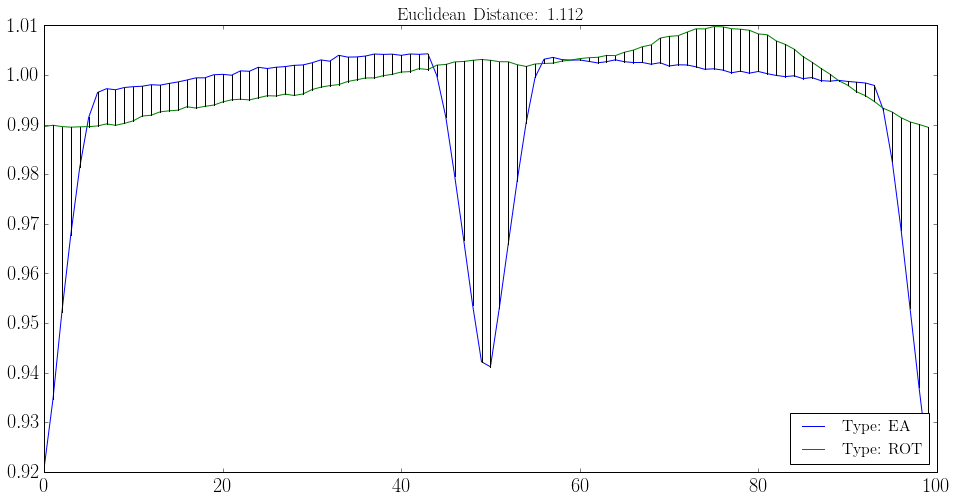

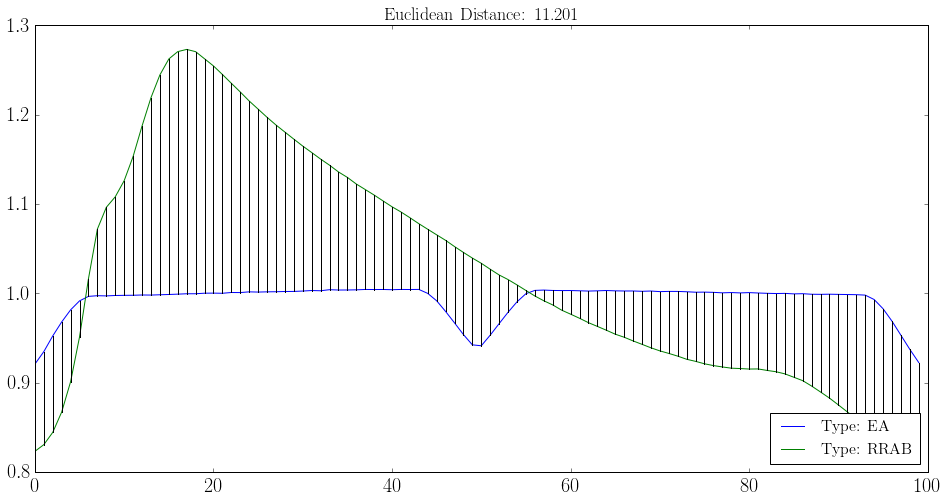

In [6]:
edist = []
for pair in combos:
    flux1 = np.array(farr[pair[0]])
    flux2 = np.array(farr[pair[1]])
    
    #Shift minimum flux to t=0
    flux1 = np.roll(np.array(flux1), tsteps-np.argmin(flux1))
    flux2 = np.roll(np.array(flux2), tsteps-np.argmin(flux2)-1)
    
    d = np.sum(np.abs(flux2 - flux1))
    edist.append(d)
    
    plt.figure(figsize=[16,8])
    plt.plot(tarr, flux1, label=f'Type: {types[pair[0]]}')
    plt.plot(tarr, flux2, label=f'Type: {types[pair[1]]}')
    for t in tarr:
        plt.plot((t, t), (flux1[t], flux2[t]), color='k')
    plt.title(f'Euclidean Distance: {str(np.round(d,3))}', fontsize=18)
    plt.legend(loc='lower right', fontsize=16)
    plt.ticklabel_format(useOffset=False)
    plt.show()

### Dynamic Time Warping 

In [7]:
# https://github.com/talcs/simpledtw

def dtw(series_1, series_2, norm_func=np.linalg.norm):
    matrix = np.zeros((len(series_1) + 1, len(series_2) + 1))
    matrix[0,:] = np.inf
    matrix[:,0] = np.inf
    matrix[0,0] = 0
    for i, vec1 in enumerate(series_1):
        for j, vec2 in enumerate(series_2):
            cost = norm_func(vec1 - vec2)
            matrix[i + 1, j + 1] = cost + min(matrix[i, j + 1], matrix[i + 1, j], matrix[i, j])
    matrix = matrix[1:,1:]
    i = matrix.shape[0] - 1
    j = matrix.shape[1] - 1
    matches = []
    mappings_series_1 = [list() for v in range(matrix.shape[0])]
    mappings_series_2 = [list() for v in range(matrix.shape[1])]
    while i > 0 or j > 0:
        matches.append((i, j))
        mappings_series_1[i].append(j)
        mappings_series_2[j].append(i)
        option_diag = matrix[i - 1, j - 1] if i > 0 and j > 0 else np.inf
        option_up = matrix[i - 1, j] if i > 0 else np.inf
        option_left = matrix[i, j - 1] if j > 0 else np.inf
        move = np.argmin([option_diag, option_up, option_left])
        if move == 0:
            i -= 1
            j -= 1
        elif move == 1:
            i -= 1
        else:
            j -= 1
    matches.append((0, 0))
    mappings_series_1[0].append(0)
    mappings_series_2[0].append(0)
    matches.reverse()
    for mp in mappings_series_1:
        mp.reverse()
    for mp in mappings_series_2:
        mp.reverse()

    return matches, matrix[-1, -1], mappings_series_1, mappings_series_2, matrix

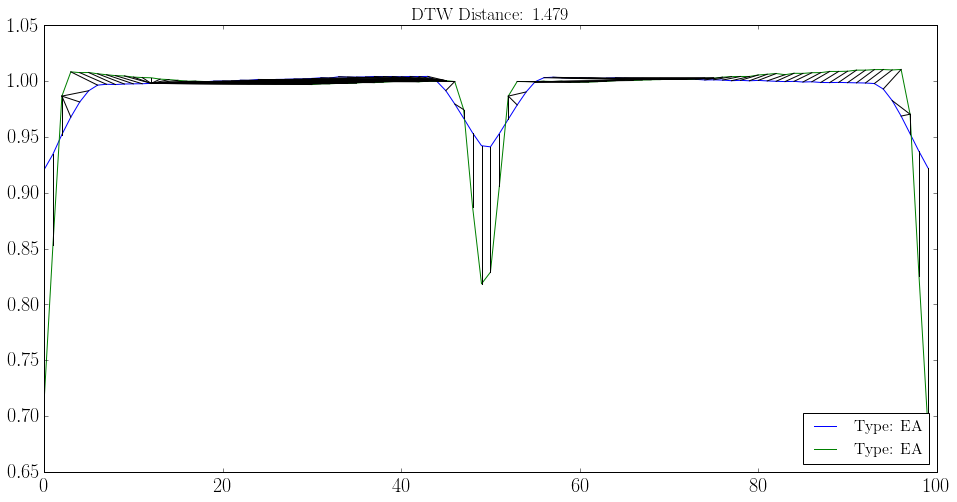

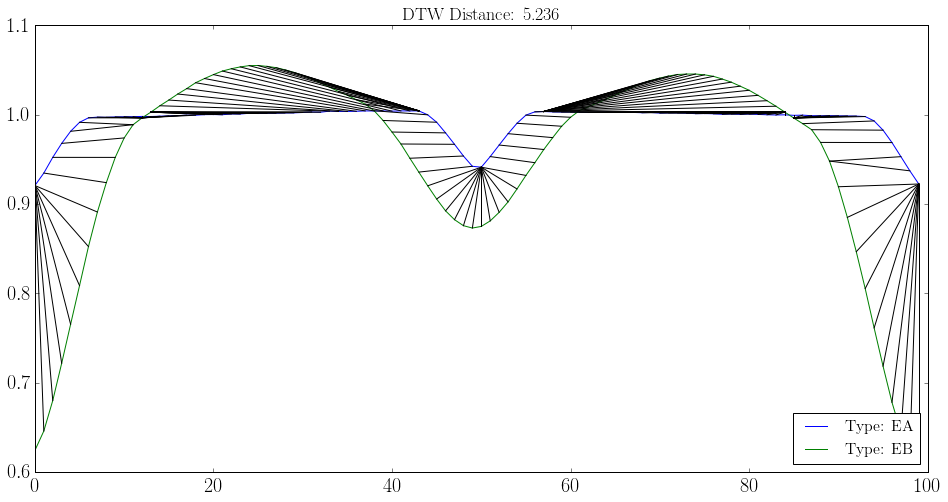

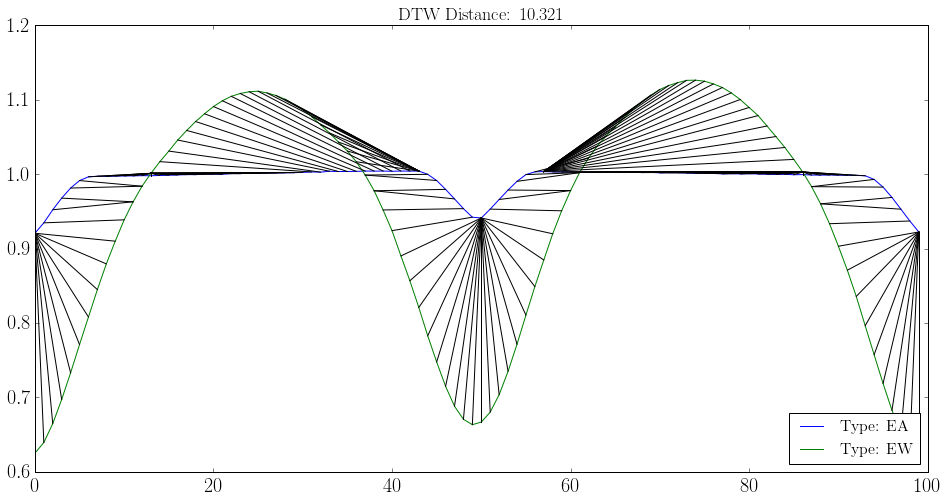

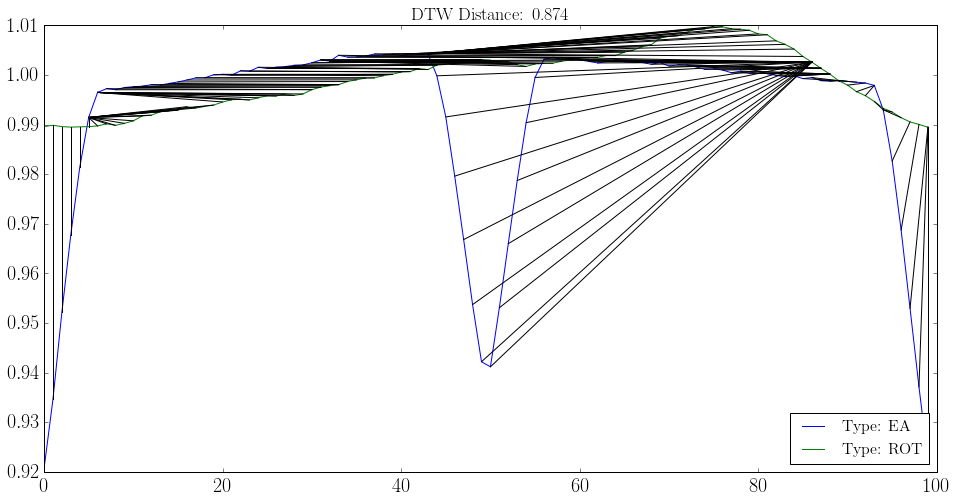

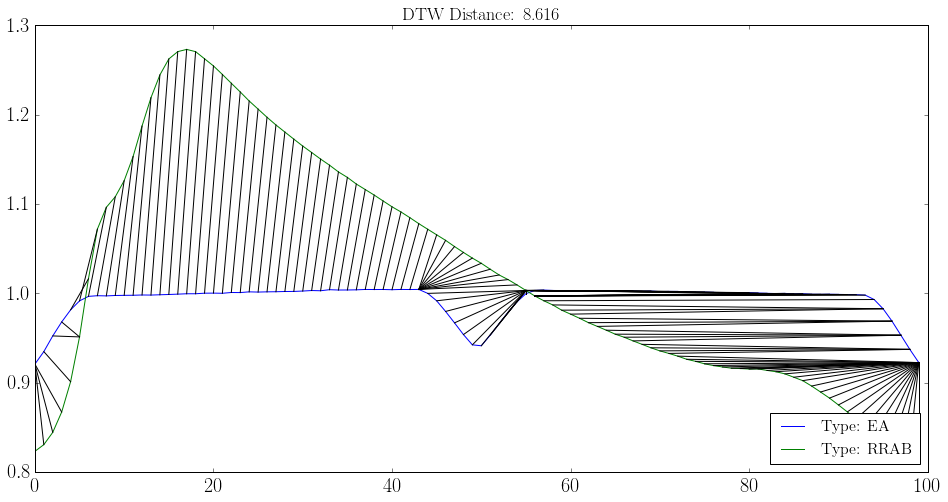

In [8]:
dtw_dist = []
for pair in combos:
    flux1 = np.array(farr[pair[0]])
    flux2 = np.array(farr[pair[1]])
    
    #Shift minimum flux to t=0
    flux1 = np.roll(np.array(flux1), tsteps-np.argmin(flux1))
    flux2 = np.roll(np.array(flux2), tsteps-np.argmin(flux2)-1)
    
    matches, cost, mapping_1, mapping_2, matrix = dtw(flux1, flux2)
    
    d = cost
    dtw_dist.append(d)
    
    plt.figure(figsize=[16,8])
    plt.plot(tarr, flux1, label=f'Type: {types[pair[0]]}')
    plt.plot(tarr, flux2, label=f'Type: {types[pair[1]]}')
    
    for m in matches:
        plt.plot((tarr[m[0]], tarr[m[1]]), (flux1[m[0]], flux2[m[1]]), color='k')
    plt.title(f'DTW Distance: {str(np.round(d,3))}', fontsize=18)
    plt.legend(loc='lower right', fontsize=16)
    plt.ticklabel_format(useOffset=False)
    plt.show()

In [12]:
np.vstack([edist, dtw_dist]).T

array([[ 1.6319418 ,  1.47942096],
       [ 7.0479455 ,  5.23627204],
       [12.46107388, 10.32109487],
       [ 1.11193466,  0.87405622],
       [11.20125484,  8.6161775 ]])

### DTW-D 

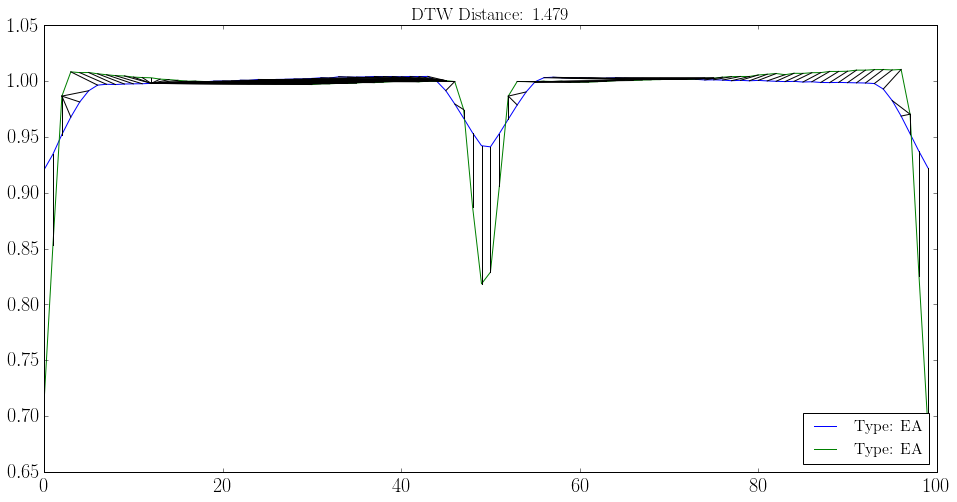

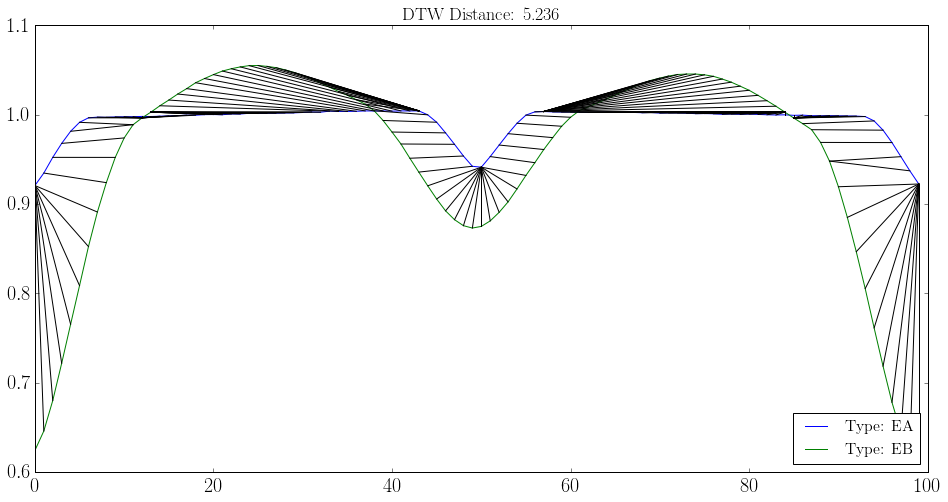

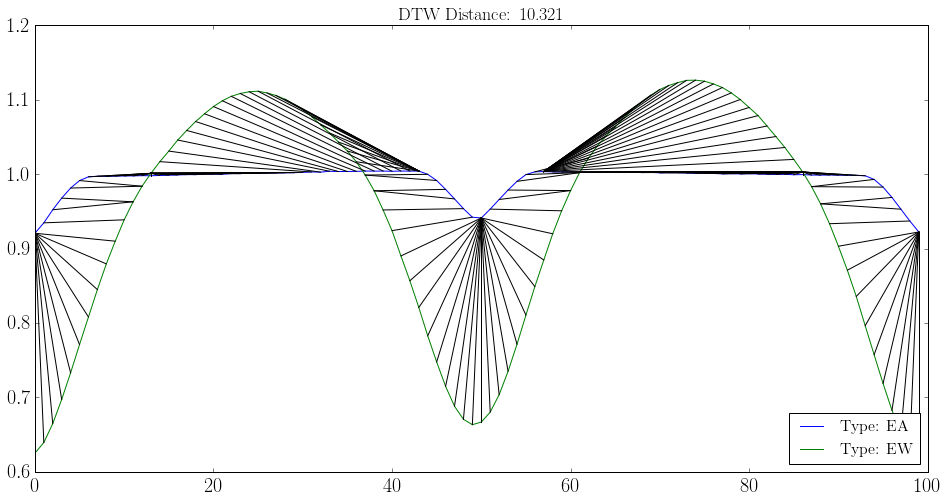

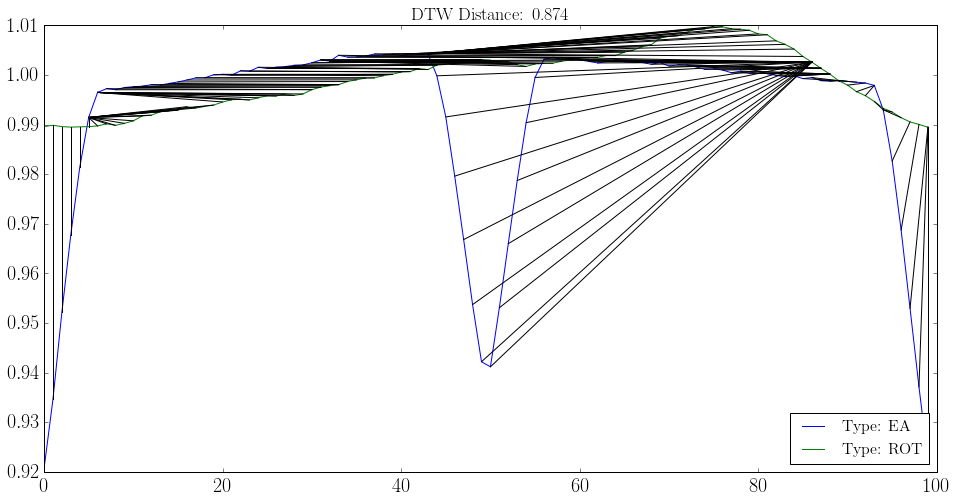

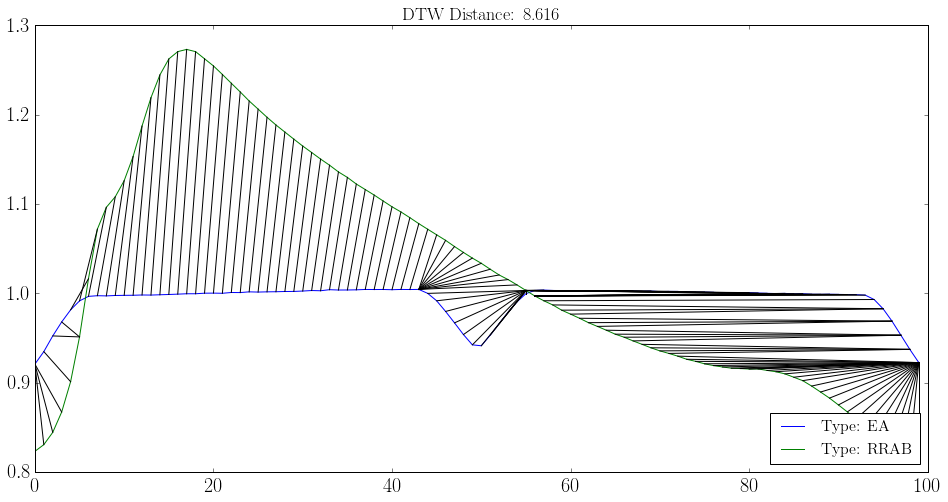

In [16]:
dtwd_dist = []
for pair in combos:
    flux1 = np.array(farr[pair[0]])
    flux2 = np.array(farr[pair[1]])
    
    #Shift minimum flux to t=0
    flux1 = np.roll(np.array(flux1), tsteps-np.argmin(flux1))
    flux2 = np.roll(np.array(flux2), tsteps-np.argmin(flux2)-1)
    
    matches, cost, mapping_1, mapping_2, matrix = dtw_d(flux1, flux2)
    
    d = cost
    dtw_dist.append(d)
    
    plt.figure(figsize=[16,8])
    plt.plot(tarr, flux1, label=f'Type: {types[pair[0]]}')
    plt.plot(tarr, flux2, label=f'Type: {types[pair[1]]}')
    
    for m in matches:
        plt.plot((tarr[m[0]], tarr[m[1]]), (flux1[m[0]], flux2[m[1]]), color='k')
    plt.title(f'DTW-D Distance: {str(np.round(d,3))}', fontsize=18)
    plt.legend(loc='lower right', fontsize=16)
    plt.ticklabel_format(useOffset=False)
    plt.show()